# Introduction

The aim of this project is to help real estate investors predict prices for a given property. Some real estate investors don't have data-driven insight into how much they should pay for a given property and quite often end up paying too much. In order to make an educated investment, an investor needs to know what aspects give a real estate property its value. Our aim is to use data visualization in order to interactively and efficiently convey insights to investors to help them make better investment decisions. Through analysis, an investor can understand which features of a property (i.e Number of bathrooms, location, house age) influence the listing price of a property. If all features match up, an investor can be sure that they are getting a fair price for a given property.In this notebook, we take advantage of the columns available in the Ames dataset to predict the value of a property. 

## Description of Data 

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. The data set describes the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.Data was obtained from Kaggle [1]. The columns in this dataset include features like LandSlope, LotSize, Overall Condition, Overall Quality, Basement Overall Condition, Basement Overall Quality, and House age. In total the data set has 80 columns that represent useful features when assessing the price of a home. A full description of the data can be found inside data_description.txt file inside the project zip file.

## Objective

The objective of this project is to figure out which features of the data correlate to sale price and to predict the price of a home given a set of features. For a real estate investor, this translates to the aspects of a real estate property that an investor should look for when purchasing a property


In [327]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
import warnings

#ignore warnings
warnings.filterwarnings('ignore')

#Show all columns
pd.set_option('display.max_columns', None)

%matplotlib inline

#read dataset 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#print top 5
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Analyzing Home Sale Price

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Median price: $163000.0 



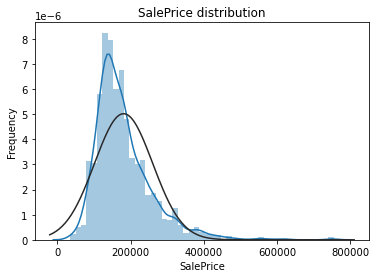

    Skewness: 1.8828757597682129
    Kurtosis: 6.536281860064529


In [328]:
from scipy.stats import norm
import seaborn as sns

#print measures of central tendency
print(train['SalePrice'].describe())
print("\nMedian price: ${} \n".format(train['SalePrice'].median()))

#build distribution plot
plt.title('SalePrice distribution')
plt.ylabel('Frequency')
plt.xlabel("Price")
sns.distplot(train['SalePrice'] , fit=norm);

#Show plot and print stats
plt.show()
print("    Skewness: {}".format(train['SalePrice'].skew()))
print("    Kurtosis: {}".format(train['SalePrice'].kurt()))

SalePrice is the variable we are trying to predict. Take note that the data provided here is specifically for Ames, Iowa. We see that the median home price in Ames, Iowa is 163000 and the average home price is 180921.

## Preprocessing

First, we need to get some info on each row to see if there are any duplicates and we need to get the shape of the data to see how many rows and columns are available in the training data. Moreover, we need to get the sum of null values found in each column and we need to use imputation to deal with missing values in our dataset.

In [329]:
#drop id column as it is not needed and drop utilities column as it repeats a single value
train.drop(train.columns[[0,9]], axis = 1, inplace=True)
test.drop(test.columns[[0,9]], axis = 1, inplace=True)

#print shape of train data
print("Train Data: Rows = {}, Columns = {} \n".format(train.shape[0], train.shape[1]))
print("Train Data # of duplicated rows: {} \n".format(train.duplicated().sum()))

#print data types for each column
print(train.info())
print("\n")

#print shape of test data
print("Test Data: Rows = {}, Columns = {} \n".format(test.shape[0], test.shape[1]))
print("Test Data # of duplicated rows: {} \n".format(test.duplicated().sum()))

print(test.info())

Train Data: Rows = 1460, Columns = 79 

Train Data # of duplicated rows: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460

In [330]:
#Get number of categorical and numerical columns
cat_cols = len(train.select_dtypes(include=['object']).columns)
num_cols = len(train.select_dtypes(include=['int64','float64']).columns)

print("Categorical: {}, Numerical: {}, Total Features: {}".format(cat_cols, num_cols, cat_cols+num_cols))

Categorical: 42, Numerical: 37, Total Features: 79


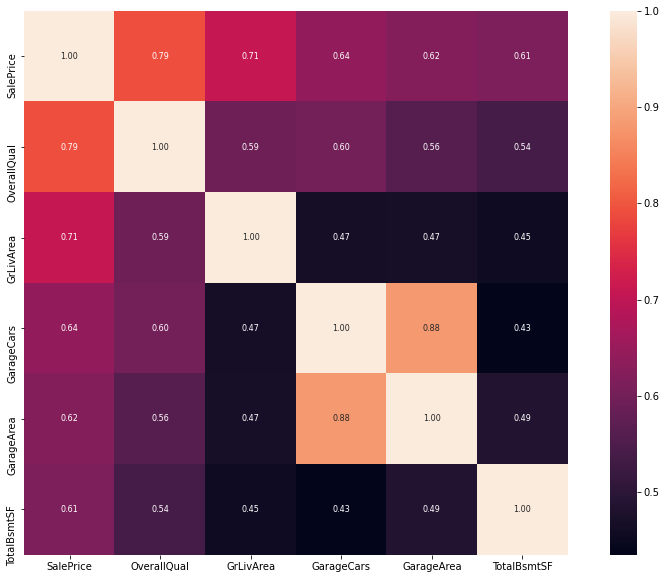

In [331]:
#Need to get correlation matrix for SalePrice
matrix = train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

#Build correlation Matrix for top 5 most correlated variables with SalePrice
columns = matrix.nlargest(6, 'SalePrice')['SalePrice'].index
cmap = np.corrcoef(train[columns].values.T)

#build heat map
sns.heatmap(cmap, cbar=True, annot=True, 
                      square=True, fmt='.2f', 
                      annot_kws={'size': 8}, 
                      yticklabels=columns.values, 
                      xticklabels=columns.values)



From the correlation matrix, we can see that OverallQual is the feature that most correlates with the sale price. We see that OverallQual, GrLivArea, GarageCars, GarageArea, and TotalBsmtSF are the 5 variables that correlate the most with Sale price. This makes sense as these are typical features investors look for. Below we investigate the relationship between the sale price and these five features and clean the data from outliers.   

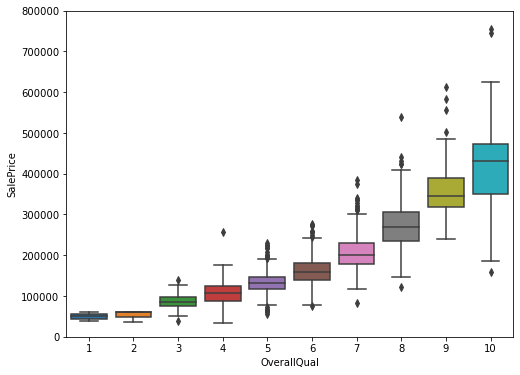

In [332]:
# Overall Quality vs Sale Price
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

The OverallQual correlates well with the sale price and we don't see any outliers that need to be filtered out. Filtering outliers will help to make the training data more robust.

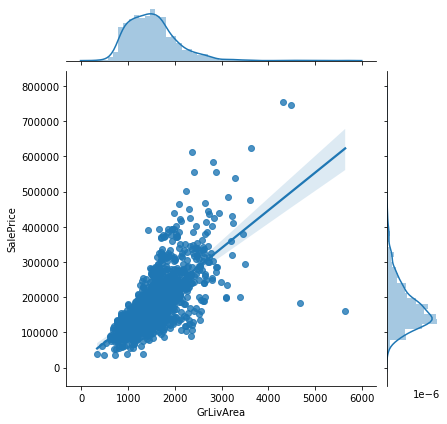

In [333]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

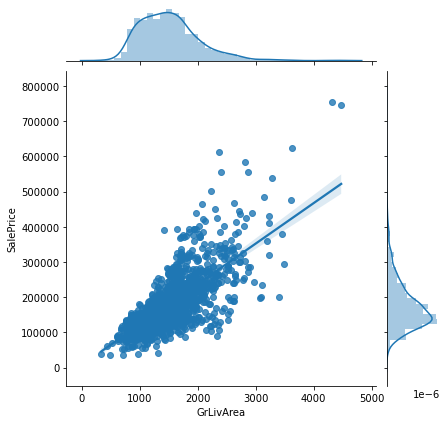

In [334]:
#remove two outliers in bottom right quadrant
train = train.drop(train[(train['GrLivArea']>4500) 
                         & (train['SalePrice']<200000)].index).reset_index(drop=True)

# check to see if outliers are removed
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

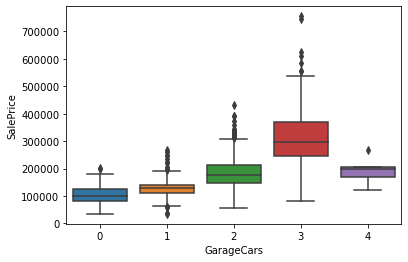

In [335]:
# Garage Cars vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

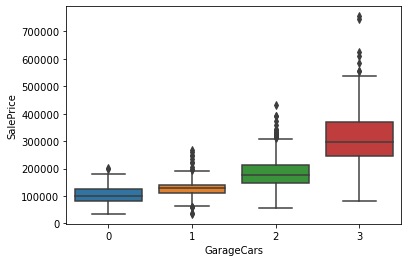

In [336]:
# Drop the fourth box plot as it shows clear outliers
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

# Check to see that the outlier was removed
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

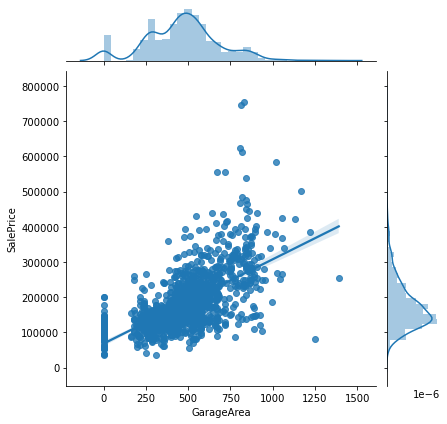

In [337]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

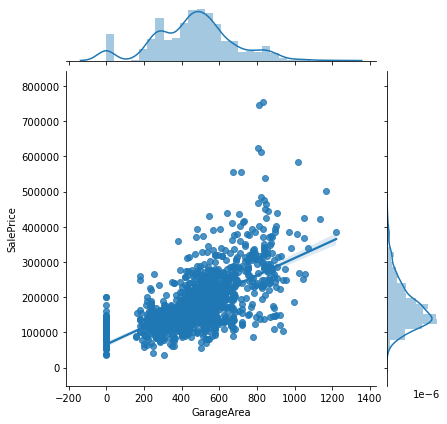

In [338]:
## Two outliers in bottom right quadrant
train = train.drop(train[(train['GarageArea']>1200) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

# Check to see if outliers were removed
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

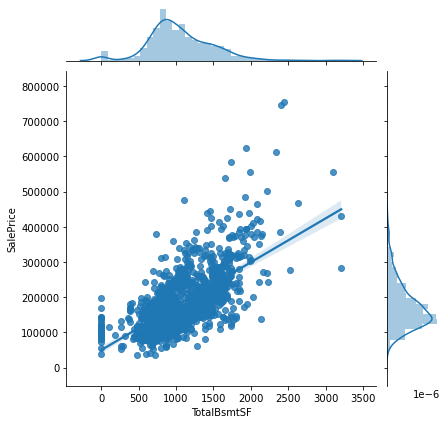

In [339]:
# TotalBsmtSF vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

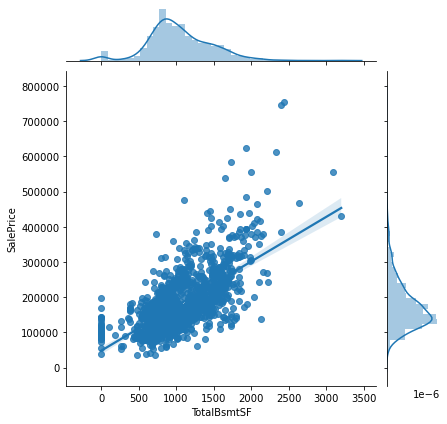

In [340]:
## Two outliers in bottom right quadrant
train = train.drop(train[(train['TotalBsmtSF']>2500) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

# Check to see if removed
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

In [341]:
#print shape of train data after cleaning
print("Train Data: Rows = {}, Columns = {} \n".format(train.shape[0], train.shape[1]))
print("Train Data # of duplicated rows: {} \n".format(train.duplicated().sum()))

#print data types for each column
print(train.info())
print("\n")

#print shape of test data after cleaning
print("Test Data: Rows = {}, Columns = {} \n".format(test.shape[0], test.shape[1]))
print("Test Data # of duplicated rows: {} \n".format(test.duplicated().sum()))

print(test.info())

Train Data: Rows = 1449, Columns = 79 

Train Data # of duplicated rows: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1449 non-null   int64  
 1   MSZoning       1449 non-null   object 
 2   LotFrontage    1191 non-null   float64
 3   LotArea        1449 non-null   int64  
 4   Street         1449 non-null   object 
 5   Alley          90 non-null     object 
 6   LotShape       1449 non-null   object 
 7   LandContour    1449 non-null   object 
 8   LotConfig      1449 non-null   object 
 9   LandSlope      1449 non-null   object 
 10  Neighborhood   1449 non-null   object 
 11  Condition1     1449 non-null   object 
 12  Condition2     1449 non-null   object 
 13  BldgType       1449 non-null   object 
 14  HouseStyle     1449 non-null   object 
 15  OverallQual    1449 non-null   int64  
 16  OverallCond    1449

### Preprocessing Categorical data

We need to preprocess categorical data in order impute null values by either replacing the with the mode or removing them all together. Moreover, categorical data needs to be encoded before it can be fed into a machine learning model. We use one-hot encoding for categorical variables that do not have a natural rank ordering and How to use ordinal encoding for categorical variables that have a natural rank ordering.

In [342]:
# save train index to retreive later
train_index = train.shape[0]

#concatenate train and test data and drop Sale price from it
combined_data = pd.concat((train, test)).reset_index(drop=True)
combined_data.drop(['SalePrice'], axis=1, inplace=True)

#print new data size
print("Combined dataset => {}".format(all_data.shape))

Combined dataset => (2908, 220)


In [343]:
#MSSubClass is the building class/code
combined_data['MSSubClass'] = combined_data['MSSubClass'].apply(str)

#Lot frontage replace with median within the same neighborhood
combined_data["LotFrontage"] = combined_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

## as per data_description None in the functional column means typical
combined_data["Functional"] = combined_data["Functional"].fillna("Typ")

#Columns where NA can be replaced with None
columns_none = ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','MasVnrType',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
          )

#columns where NA can be replaced with 0
columns_0 = ('MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath'
            )

#columns where NA can be replace with the mode of that column
columns_mode = ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType')

#Columns that need to be transformed into categorical variables
columns_transform = ('OverallCond', 'YrSold', 'MoSold')

#replace NA with None
for col in columns_none:
    combined_data[col] = combined_data[col].fillna('None')


#replace NA with 0
for col in columns_0:
    combined_data[col] = combined_data[col].fillna(0)
    

## Replace NA values using mode
for col in columns_mode:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mode()[0])

#transform into categorical variables
for col in columns_transform:
    combined_data[col] = all_data[col].astype(str)


In [344]:
from sklearn.preprocessing import LabelEncoder

#Columns that need to be encoded
columns_encode = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns and apply LabelEncoder to categorical features
for col in columns_encode:
    lbl = LabelEncoder() 
    lbl.fit(list(combined_data[col].values)) 
    all_data[col] = lbl.transform(list(combined_data[col].values))
    
    
# Add Total Square Feet as a new feature 
combined_data['TotalSF'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF']

# Check shape        
print('Shape of combined data => {}'.format(combined_data.shape))

Shape of combined data => (2908, 79)


In [345]:
#normalize SalePrice values and store into y_train
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train.SalePrice.values

#Convert categorical variable into dummy/indicator variables.
combined_data = pd.get_dummies(all_data)

train = combined_data[:train_index]
test = combined_data[train_index:]

print("Shape of Train => {}".format(train.shape))
print("Shape of Test => {}".format(test.shape))

(1449, 220)
(1459, 220)


## ML MODELING 

The model used here is Lasso Regression. Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean.. [2].

In [368]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# Use lasso Regression Model
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(train.values,y_train)

##Prediction for test values
lasso_predict = np.expm1(lasso.predict(test.values))

print(lasso_predict)

[119319.78892052 155243.22471564 184121.81584784 ... 174950.12606592
 119371.84999318 226248.90335802]


## Evaluating Prediction Results

To evaluate the prediction results on the test set, we want to see if the prediction price statistics closely resemble the sales price statistics derived from the training set. We predict that the predicted prices will have a mean around 180000 and a mode near 160000, as this was observed with the sales prices from the tests set.


Median price: $158231.00829605598 


Mean price: $178111.1651680101 



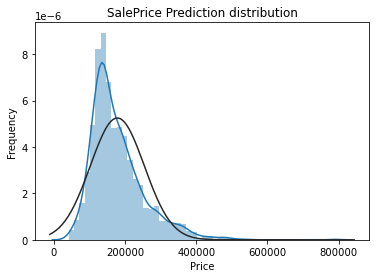

In [373]:
## Evaluating Prediction Results
#print median
print("\nMedian price: ${} \n".format(np.median(lasso_predict)))
print("\nMean price: ${} \n".format(np.mean(lasso_predict)))

#build distribution plot
plt.title('SalePrice Prediction distribution')
plt.ylabel('Frequency')
plt.xlabel("Price")
sns.distplot(lasso_predict , fit=norm);

#Show plot and print stats
plt.show()

## Evaluation ML Model

We can use cross-validation with k folds (usually 5 or 10 folds). K-fold cross validation is a procedure used to estimate the skill of the model on new data. This method shuffles the dataset randomly and splits the data into k groups.

In [394]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import math


# Root mean squared cross validation
def cross_validate(model, k_folds):
    kf = KFold(k_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    error= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(error)

score = cross_validate(lasso,10)
print("Lasso score: {:.5f} ({:.5f}) Mean Squared Error \n".format(score.mean(), score.std()))
print("Normalized Predicted Values")
print(lasso.predict(test.values))

Lasso score: 0.10975 (0.01376) Mean Squared Error 

Normalized Predicted Values
[11.68957085 11.9527548  12.12335829 ... 12.07226193 11.69000707
 12.32939543]


## Conclusion 

A lasso score of 0.10975 is the Root Mean Squared Error on the predicted normalized Sale Price values. In order to convert these normalized values back to real Sale Price values, you would convert using np.expm1 which calculates "exp(normalized value) - 1". This score is actually very good considering the normalized values fall in between 10 and 13. We can safely assume that our model would perform well on new and independent data.

### References: 
[1] https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

[2] Tibshirani, Robert (1996). "Regression Shrinkage and Selection via the lasso". Journal of the Royal Statistical Society. Series B (methodological). Wiley. 58 (1): 267–88. JSTOR 2346178.

[3] https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning